In [1]:

import pandas as pd
import numpy as np

import time
import pickle

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.datasets import make_blobs, make_moons, load_iris, load_digits
from sklearn.cluster import *
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import homogeneity_score, homogeneity_completeness_v_measure
from sklearn.preprocessing import scale
from collections import Counter

import hdbscan
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

In [27]:
#load in the data from the pickle objects
all_schools = pd.read_pickle("allschools_df.pkl")
public_schools = pd.read_pickle("public_df.pkl")
for_profit = pd.read_pickle("forprofit_df.pkl")
non_profit = pd.read_pickle("nonprofit_df.pkl")

allschoolsPCA = pd.read_pickle("allschoolsPCA.pkl")
publicPCA = pd.read_pickle("publicschoolPCA.pkl")
nonprofitPCA = pd.read_pickle("nonprofitPCA.pkl")
forprofitPCA = pd.read_pickle("forprofitPCA.pkl")

In [ ]:
#adapted from https://stackoverflow.com/questions/25633383/how-can-gridsearchcv-be-used-for-clustering-meanshift-or-dbscan

def dbscan_grid_search(X_data, lst, clst_count, eps_space = 0.5,
                       min_samples_space = 5, min_clust = 0, max_clust = 10):

    """
Performs a hyperparameter grid search for DBSCAN.

Parameters:
    * X_data            = data used to fit the DBSCAN instance
    * lst               = a list to store the results of the grid search
    * clst_count        = a list to store the number of non-whitespace clusters
    * eps_space         = the range values for the eps parameter
    * min_samples_space = the range values for the min_samples parameter
    * min_clust         = the minimum number of clusters required after each search iteration in order for a result to be appended to the lst
    * max_clust         = the maximum number of clusters required after each search iteration in order for a result to be appended to the lst

"""
    # Starting a tally of total iterations
    n_iterations = 0

    # Looping over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:

            dbscan_grid = DBSCAN(eps = eps_val,
                                 min_samples = samples_val)

            # fit_transform
            clusters = dbscan_grid.fit_predict(X = X_data)

            labels = dbscan_grid.labels_

            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            

            # Counting the amount of data in each cluster
            cluster_count = Counter(clusters)

            # Saving the number of clusters
            n_clusters = sum(abs(pd.np.unique(clusters))) - 1

            # Increasing the iteration tally with each run of the loop
            n_iterations += 1

            # Appending the lst each time n_clusters criteria is reached
            if n_clusters >= min_clust and n_clusters <= max_clust:
                
                lst.append(["Epsilon: %d" % eps_val,
                                        "Minimum points: %d" % samples_val,
                                        "Number of clusters: %d" % n_clusters_,
                                       "Estimated number of noise points: %d" % n_noise_,
                                       "Homogeneity: %0.3f" % metrics.homogeneity_score(X_data[:, 1], labels),
                                       "Completeness: %0.3f" % metrics.completeness_score(X_data[:, 1], labels),
                                       "V-measure: %0.3f" % metrics.v_measure_score(X_data[:, 1], labels),
                                       "Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(X_data[:, 1], labels),
                                       "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_data[:, 0].reshape(-1,1), labels)])

                clst_count.append(cluster_count)

    # Printing grid search summary information
    print(f"""Search Complete. \nYour list is now of length {len(lst)}. """)
    print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")


### Clustering w/ DBSCAN for Principal Components of all school data

In [ ]:
%%time
# Setting empty lists in global environment
dbscan_clusters = []
cluster_count   = []


# Inputting function parameters
dbscan_grid_search(X_data = allschoolsPCA,
                   lst = dbscan_clusters,
                   clst_count = cluster_count,
                   eps_space = pd.np.arange(0.1, 4, 0.5),
                   min_samples_space = pd.np.arange(10, 250, 25),
                   min_clust = 2,
                   max_clust = 20)

In [ ]:
dbscan_clusters

In [ ]:
#put the list of results into pickle objects
with open('all_cluster_PCA_list.pkl', 'wb') as f:
    pickle.dump(dbscan_clusters, f)

In [ ]:
#read the pickle back in
with open('all_cluster_PCA_list.pkl', 'rb') as f:
    all_cluster_result = pickle.load(f)

In [ ]:
final_dbscan_model_all = DBSCAN(eps=7, min_samples=20)
final_dbscan_model_all.fit(dbscan_X_scaled)
y_pred = final_dbscan_model_all.fit_predict(dbscan_X_scaled)

dblabels = final_dbscan_model_all.labels_
all_n_clusters_ = len(set(dblabels)) - (1 if -1 in dblabels else 0)

print("Number of clusters: %d" % all_n_clusters_)


In [ ]:

plt.figure(figsize=(10, 10))
plt.scatter(dbscan_X_scaled[:,-5], dbscan_X_scaled[:, -8], c=dblabels,  marker="o", 
            alpha=0.3, cmap='plasma')

plt.xlim(dbscan_X_scaled[:, -5].min()-1, dbscan_X_scaled[:, -5].max()+1)
plt.ylim(dbscan_X_scaled[:, -8].min()-1, dbscan_X_scaled[:, -8].max()+1)

plt.show()

### HDBSCAN with Principal Components of All Schools

In [3]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=25)
cluster_labels = clusterer.fit_predict(allschoolsPCA)
hdlabels = clusterer.labels_

CPU times: user 968 ms, sys: 5.24 ms, total: 973 ms
Wall time: 329 ms


In [4]:
clusterList = list(zip(hdlabels, allschoolsPCA.index.values))
len(clusterList)

6692

In [5]:

for i in sorted(clusterList, key=lambda x: x[0]):
    if i[0] < 0:
        clusterList.remove(i)

In [6]:
len(clusterList)

664

In [14]:
sorted_ClusterList = sorted(clusterList, key=lambda x: x[0])
#sorted_ClusterList

In [8]:
# this cell creates a rotating 3D plot in a pop up window
from matplotlib import interactive
interactive(True)
%matplotlib qt

num_clusters = clusterer.labels_.max()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

color_palette = sns.color_palette('bright', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.9, 0.9, 0.9)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
ax.scatter(allschoolsPCA.PC1, allschoolsPCA.PC2, allschoolsPCA.PC3, linewidth=0, 
                  c=cluster_member_colors, alpha=0.4)


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title("Hierarchical DBSCAN w/ %d Clusters" % num_clusters)

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)


<Figure size 1152x792 with 0 Axes>

<function matplotlib.pyplot.show(*args, **kw)>

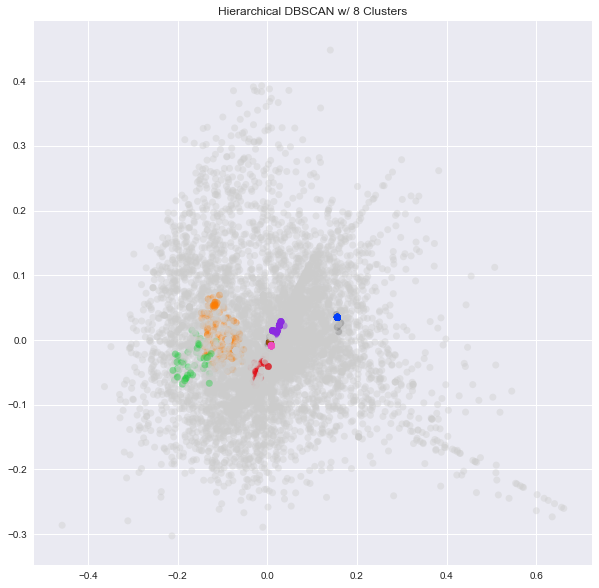

In [12]:
#2D scatter plot of top 2 PC's
%matplotlib inline
plt.figure(figsize=(10, 10))

color_palette = sns.color_palette('bright', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.8, 0.8, 0.8)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(allschoolsPCA.PC1, allschoolsPCA.PC2,  linewidth=0, c=cluster_member_colors, alpha=0.4)
plt.title("Hierarchical DBSCAN w/ %d Clusters" % (num_clusters + 1))

plt.show

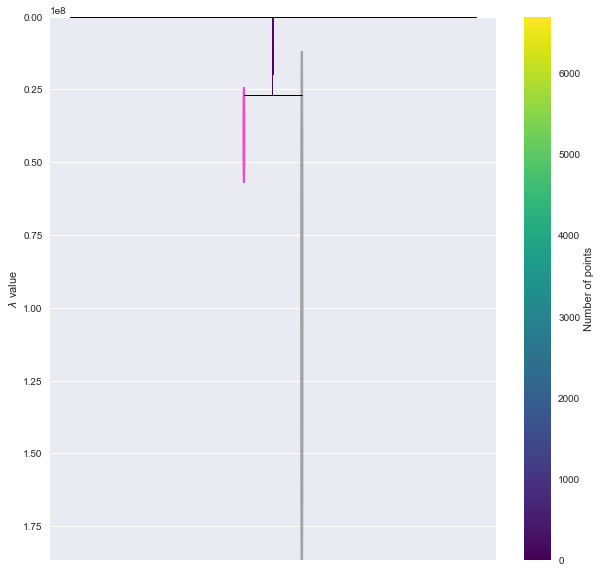

In [13]:
#dendogram of the clusters
%matplotlib inline
plt.figure(figsize=(10, 10))
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('bright', 8))

In [17]:
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []

for i in sorted_ClusterList:
    if i[0] == 0:
        cluster1.append(i)
    elif i[0] == 1:
        cluster2.append(i)
    elif i[0] == 2:
        cluster3.append(i)
    elif i[0] == 3:
        cluster4.append(i)
    elif i[0] == 4:
        cluster5.append(i)
    elif i[0] == 5:
        cluster6.append(i)
    elif i[0] == 6:
        cluster7.append(i)
    elif i[0] == 7:
        cluster8.append(i)
    

In [51]:
# df2 = df2.append(df1[df1['Adj.Factor'] == 0])
new = [] 

for school in cluster1:
    if school[1].all(all_schools.index) == True:
            new.append(all_schools['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'].values)
        

AttributeError: 'str' object has no attribute 'all'

In [45]:
type(new)

list

In [52]:
cluster1

[(0, 'University of Phoenix-Hawaii'),
 (0, 'University of the Potomac-VA Campus'),
 (0, 'Strayer University-Alabama'),
 (0, 'Strayer University-Arkansas'),
 (0, 'University of Phoenix-Georgia'),
 (0, 'University of Phoenix-Nevada'),
 (0, 'University of Phoenix-Tennessee'),
 (0, 'University of Phoenix-Texas'),
 (0, 'Strayer University-Takoma Park Campus'),
 (0, 'Strayer University-Alexandria Campus'),
 (0, 'Strayer University-Woodbridge Campus'),
 (0, 'Strayer University-Manassas Campus'),
 (0, 'Strayer University-Loudoun Campus'),
 (0, 'Strayer University-Fredericksburg Campus'),
 (0, 'Strayer University-Henrico Campus'),
 (0, 'Strayer University-Chesterfield Campus'),
 (0, 'Strayer University-Chesapeake Campus'),
 (0, 'Strayer University-Newport News Campus'),
 (0, 'Strayer University-Virginia Beach Campus'),
 (0, 'Strayer University-Rockville Campus'),
 (0, 'Strayer University-Anne Arundel Campus'),
 (0, 'Strayer University-White Marsh Campus'),
 (0, 'Strayer University-Owings Mills 

In [50]:
all_schools.index.any(school[1])

'Alabama A & M University'